# Training ML Model

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacy.tokens import Doc
import csv
import altair as alt

# disable max rows in altair
alt.data_transformers.disable_max_rows()

In [145]:
# read in rating data
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)
# drop the quote & unnamed 0
ratings.drop(columns=['quote'],inplace=True)
# replace ratings of -1 (irrelevant) with the max value
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
# rename columns
ratings.columns = ['index','query','bm25','prevbm25','nextbm25','ranking']
ratings.head()

,index,query,bm25,prevbm25,nextbm25,ranking
0,113689,lwaxana,12.436612,0.000000,0.0,21
1,113558,lwaxana,12.436612,0.000000,0.0,21
2,113532,lwaxana,12.436612,0.000000,0.0,21
3,55180,lwaxana,12.436612,8.857818,0.0,21
4,55060,lwaxana,12.436612,0.000000,0.0,21


In [146]:
# read in the complete data
complete = pd.read_csv('complete_sentiment.csv',index_col=0)
# drop unneeded columns
complete.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
# fill na characters
complete['character'] = complete['character'].fillna('NA')
complete.head(2)

,index,line,character,quote,scene,location,view,episode,date,series,file,sentiment
0,0,0,QUARK,"You know, Morn -- there's nothing quite as inv...",Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt,0.0
1,1,1,ROM,What's this?,Al INT. QUARK'S,QUARK'S,INT.,STAR TREK: DEEP SPACE NINE,1996-08-29,Deep Space Nine,504.txt,0.0


In [147]:
# read in sentence embeddings
embed_df = pd.read_csv('st_embeddings.csv',index_col=0)
# rename columns
embed_df.columns = [f'embedding_{x}' for x in embed_df.columns]
# get an index col for merging
embed_df=embed_df.reset_index()
embed_df.head()

,index,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,0,-0.014900,-0.071977,-0.009478,-0.029031,0.014188,0.016394,0.027681,-0.037291,-0.006358,...,0.001110,0.012414,0.030341,-0.003418,-0.008822,0.033325,-0.001755,0.068690,0.020250,0.039753
1,1,-0.007164,-0.013978,-0.013652,0.003309,0.034850,0.060882,0.048588,0.017505,0.007778,...,0.022243,0.049582,-0.008420,-0.030691,-0.000645,-0.050140,0.083585,-0.046941,-0.020030,0.012742
2,2,-0.049198,-0.035306,0.008143,0.088346,0.093932,0.025349,-0.010510,-0.015539,-0.002362,...,0.003785,-0.010067,0.007732,-0.049809,0.051560,0.024296,0.035107,-0.066092,-0.020333,-0.009799
3,3,-0.043590,-0.021896,-0.019405,0.027361,-0.020508,0.035430,-0.040713,0.043625,0.065613,...,0.009547,0.010854,-0.027765,0.049275,0.023973,0.004445,0.072360,-0.029266,-0.031327,0.004318
4,4,-0.053526,0.001219,0.001101,0.031380,-0.008443,0.052395,-0.043175,-0.038514,-0.012206,...,-0.040711,0.010254,0.007623,0.042096,-0.003285,0.002070,0.003425,-0.044013,0.021388,0.001928


In [148]:
# merge dataframes ratings + quote data
full_data = ratings.merge(complete,on=['index'],how='left')
# merge with embeddings
full_data = full_data.merge(embed_df,on=['index'],how='left')
full_data.head(2)

,index,query,bm25,prevbm25,nextbm25,ranking,line,character,quote,scene,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,113689,lwaxana,12.436612,0.0,0.0,21,355,TIMICIN,Lwaxana... ?,93 INT. TRANSPORTER ROOM,...,0.009880,-0.042633,-0.056167,0.008068,0.013000,-0.046821,0.00999,0.005621,0.028357,0.019484
1,113558,lwaxana,12.436612,0.0,0.0,21,224,TIMICIN,Lwaxana...,63 INT. TIMICIN'S QUARTERS,...,0.011101,-0.056366,-0.052283,0.000956,0.000591,-0.030117,-0.00134,0.000045,0.005712,0.018245


In [150]:
# feature engineering

# get the length of each quote
full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

# get the total quotes per character across ALL series (Worf & O'Brien)
quote_count = complete.groupby('character').count()['quote']
full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])

# get the character overall quotes in episode
ep_quote = complete.groupby(['character','file']).count()['quote']
full_data['episode_quotes']=full_data.apply(lambda x: ep_quote[x['character'],x['file']],axis=1)

# get previous quote info
complete['prev_character']=complete['character'].shift(1)
complete['prev_sent']=complete['sentiment'].shift(1)
complete['prev_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(1)
full_data = pd.merge(full_data,complete[['prev_character','prev_quote_len','prev_sent','index']],on='index',how='left')

# get next quote info
complete['next_character']=complete['character'].shift(-1)
complete['next_sent']=complete['sentiment'].shift(-1)
complete['next_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(-1)
full_data = pd.merge(full_data,complete[['next_character','next_quote_len','next_sent','index']],on='index',how='left')


In [122]:
# CHECK SOMETHING ABOUT THE SENTIMENT!!!?>s

# GO THROUGH & SET UP THE MARKDOWN LABELS

In [151]:
# Now that we have all the data, we need to train + test


# train test split my data
train, test = train_test_split(full_data,test_size=.2,random_state=56)
# sort my train & test values by query
train = train.sort_values('query')
test = test.sort_values('query')

In [152]:
# split into train_X, train_y, and train_groups

# these are the ranking values
train_y = list(train['ranking'])
# the input data, drop unneeded columns
train_X = train.drop(columns=['query','ranking','quote','date','index'])
# groups are the query set ups
train_groups = train['query'].value_counts().reset_index().sort_values('query')['count'].values

# these are the ranking values
test_y = list(test['ranking'])
# the input data, drop unneeded columns
test_X = test.drop(columns=['query','ranking','quote','date','index'])
# groups are the query set ups
test_groups = test['query'].value_counts().reset_index().sort_values('query')['count'].values

In [153]:
# one hot encode the data

# get the numerical & categorical column names
num_attribs = list(train_X.select_dtypes(include=[np.number]))
cat_attribs = list(train_X.select_dtypes(exclude=[np.number]))

# transform the data
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),   # scales the numerical attributes down!
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),    # turns the categorical term into a vector
    ])

train_prep = full_pipeline.fit_transform(train_X)
test_prep = full_pipeline.transform(test_X)

In [154]:
# get the names of the expanded columns
num_names = full_pipeline.named_transformers_["num"].get_feature_names_out(num_attribs)
cat_names = full_pipeline.named_transformers_["cat"].get_feature_names_out(cat_attribs)
total_names = list(num_attribs)+list(cat_names)

In [155]:
# create the lgbm data sets
train_data =lgb.Dataset(train_prep, label=train_y, group=train_groups,params={'min_data_in_leaf':1})
valid_data = lgb.Dataset(test_prep,label=test_y,group=test_groups)

In [156]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.01,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res = {}

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

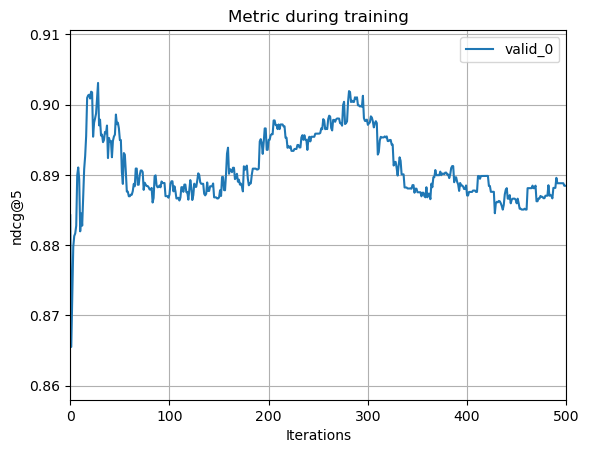

In [157]:
# create ranker model
ranker = lgb.train(params, train_data, num_boost_round=500,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

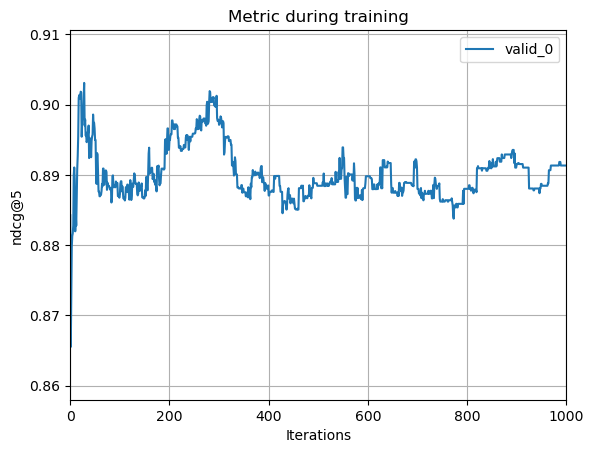

In [158]:
# create ranker model
ranker = lgb.train(params, train_data, num_boost_round=1000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

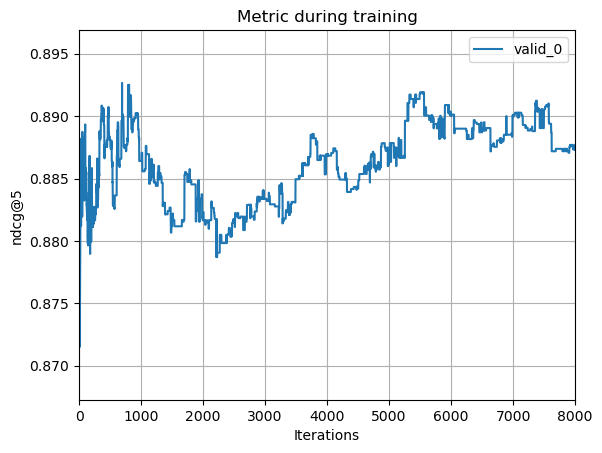

In [161]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.001,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res2 = {}
# create ranker model
ranker2 = lgb.train(params, train_data, num_boost_round=8000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res2)])
# get out the best score
ranker2.best_score
# plot the NDCG
lgb.plot_metric(res2)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/plotting.py:382: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

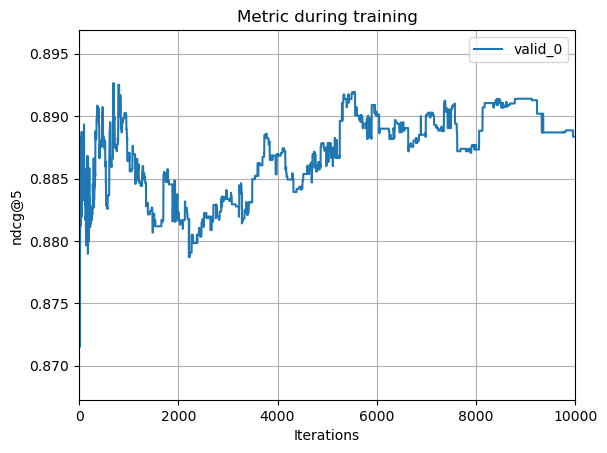

In [162]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.001,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res3 = {}
# create ranker model
ranker3 = lgb.train(params, train_data, num_boost_round=10000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res3)])
# get out the best score
ranker3.best_score
# plot the NDCG
lgb.plot_metric(res3)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

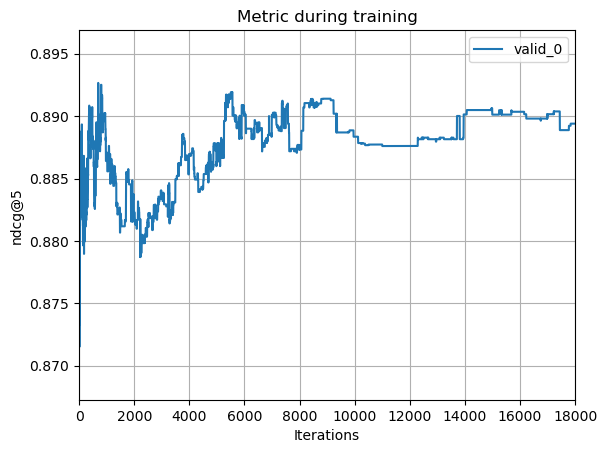

In [163]:
# set up parameters for training
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'learning_rate': 0.001,
    'num_leaves': 19,
    'task':'train',
    "num_leaves": 255,
    "feature_pre_filter": False,
    'max_depth':40,
    'verbose':-1
}
# set up results to track ndcg
res4 = {}
# create ranker model
ranker4 = lgb.train(params, train_data, num_boost_round=18000,valid_sets=[valid_data],callbacks = [lgb.record_evaluation(res4)])
# get out the best score
ranker.best_score
# plot the NDCG
lgb.plot_metric(res4)

In [ ]:
# performance
# add the page rank of characters interactions

# domain: feelings queries, people, domain specific

In [164]:
# Save this model as it is performing well!
# ranker.save_model('ranker_041025')

In [166]:
# I want to be able to get the sum of the feature importance for the features that were one-hot encoded
def get_cumulative_feature_importance(model:lgb.basic.Booster,
    column_names:list)-> pd.DataFrame:
    '''
    Gets the cumulative importance of features.

    Input:
        model: lgb.basic.Booster, the trained model
        column_names: list, a list of names of columns

    Output:
        pd.DataFrame, data frame with columns for group, feature, and importance
    '''
    importance_list = model.feature_importance('split')
    column_groups = [x[:x.rindex('_')] if '_' in x else x for x in column_names]
    importance_df = pd.DataFrame([column_groups,column_names,importance_list], index=['Group', 'Feature','Importance']).T
    return(importance_df)

In [167]:
# get the feature importance df
features = get_cumulative_feature_importance(ranker,total_names)
features.head()

,Group,Feature,Importance
0,bm25,bm25,5836
1,prevbm25,prevbm25,1844
2,nextbm25,nextbm25,490
3,line,line,10297
4,sentiment,sentiment,83


In [169]:
# group the features that were one-hot encoded
cumulative_features = features.groupby(['Group'])['Importance'].sum().reset_index().sort_values('Importance',ascending=False)
cumulative_features

,Group,Importance
2,embedding,500005
3,episode,11860
14,prev_quote_len,10558
5,line,10297
9,next_quote_len,10171
18,scene,8654
15,prev_sent,6384
0,bm25,5836
10,next_sent,5017
21,total_quotes,3498


In [177]:
eval_data = {'1':res['valid_0']['ndcg@1'],
            '2':res['valid_0']['ndcg@2'],
            '3':res['valid_0']['ndcg@3'],
            '4':res['valid_0']['ndcg@4'],
            '5':res['valid_0']['ndcg@5'],
            'iterations':list(range(6930))}

eval_df = pd.DataFrame(eval_data)
eval_df = pd.melt(eval_df,id_vars='iterations')

colors = ['#3bd47c','#3C91E6','#000000','#0C0A3E','#8A2BE2']


temp = alt.Chart(eval_df).mark_line(
    ).encode(
        x=alt.X('iterations',title='Model Iterations',scale=alt.Scale(domain=[0,6930])),
        y=alt.Y('value',title='Normalized Discounted Cumulative Gain',scale=alt.Scale(domain=[.6,1])),
        color = alt.Color('variable',title='Truncation Level').scale(range=colors)
    ).properties(
        width=600,
        height=300,
        title='LambdaRank Model Results'
    )

temp

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

# Now I want to turn the data preprocessing into a function so that I can apply this to incoming data!

In [178]:
def merge_data(bm25_df:pd.DataFrame,complete_df:pd.DataFrame,embed_df:pd.DataFrame):
    '''
    Merges all of the data needed into one nice frame!

    Input:
        bm25_df: pd.DataFrame, search results from simple bm25
        embed_df: pd.DataFrame, embedding data
        complete_df: pd.DataFrame, full context

    Output:
        pd.DataFrame, combined with all the data
    '''
    full_bm = bm25_df.merge(complete_df,on=['index'],how='left')
    full_em = full_bm.merge(embed_df,on=['index'],how='left')
    return(full_em)

In [181]:
def feature_engineering(full_data:pd.DataFrame,complete:pd.DataFrame)->pd.DataFrame:
    '''Add more features to the df.

    Input:
        full_data: pd.DataFrame
        complete: pd.DataFrame

    Output:
        pd.DataFrame,
    '''
    # get the length of each quote
    full_data['quote_len']=full_data['quote'].apply(lambda z: len(z.split()))

    # get the total quotes per character across ALL series (Worf & O'Brien)
    quote_count = complete.groupby('character').count()['quote']
    full_data['total_quotes_char']=full_data['character'].apply(lambda x: quote_count[x])

    # get the character overall quotes in episode
    ep_quote = complete.groupby(['character','file']).count()['quote']
    full_data['episode_quotes']=full_data.apply(lambda x: ep_quote[x['character'],x['file']],axis=1)

    # get previous quote info
    complete['prev_character']=complete['character'].shift(1)
    complete['prev_sent']=complete['sentiment'].shift(1)
    complete['prev_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(1)
    full_data = pd.merge(full_data,complete[['prev_character','prev_quote_len','prev_sent','index']],on='index',how='left')

    # get next quote info
    complete['next_character']=complete['character'].shift(-1)
    complete['next_sent']=complete['sentiment'].shift(-1)
    complete['next_quote_len']=complete['quote'].apply(lambda z: len(str(z).split())).shift(-1)
    full_data = pd.merge(full_data,complete[['next_character','next_quote_len','next_sent','index']],on='index',how='left')


In [182]:
# read in data

# read in the complete data
complete = pd.read_csv('complete_sentiment.csv',index_col=0)
# drop unneeded columns
complete.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)
# fill na characters
complete['character'] = complete['character'].fillna('NA')

# read in sentence embeddings
embed_df = pd.read_csv('st_embeddings.csv',index_col=0)
# rename columns
embed_df.columns = [f'embedding_{x}' for x in embed_df.columns]
# get an index col for merging
embed_df=embed_df.reset_index()

# read in rating data
ratings = pd.read_csv('skyeler_ranking_data.csv',index_col=0)
# drop the quote & unnamed 0
ratings.drop(columns=['quote'],inplace=True)
# replace ratings of -1 (irrelevant) with the max value
ratings.ranking = ratings.ranking.apply(lambda z: ratings.ranking.max()+1 if z < 0 else z)
# rename columns
ratings.columns = ['index','query','bm25','prevbm25','nextbm25','ranking']

In [183]:
entire_data = merge_data(bm25_df=ratings,complete_df=complete,embed_df=embed_df)
prep_data = feature_engineering(entire_data,complete)